# TFM - Predicción potenciales compradores de un ecommerce

Evolución del notebook *Modelo_1.ipynb* unicamente aplicando a **personas jurídicas**

------------------------------------

------------------

### 1.1 Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

from collections import Counter

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

------------------

### 1.2 Variables globales

In [2]:
LABELS = ["No_Cliente","Cliente"]

------------------

### 1.3 Funciones

In [3]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

------------------------------------

------------------

A continuación comenzamos leyendo los ficheros que hemos tratado, limpiado y analizado en los procesos anteriores.

Se realizará un análisis sencillo de la estructura y una visualización de varias muestras. 

Además someteremos las variables categóricas a variables *dummies*, de forma que que podamos introducirlas ennuestro modelo.

### 2.1 Lectura de Fichero

In [4]:
df = pd.read_csv('Data/dataset_model_corr.txt', sep = ';', encoding = 'ISO-8859-1')

In [5]:
df.shape

(406267, 26)

In [6]:
df.head(3)

,TIPOUSUARIO,FECHA_REGISTRO_WEEKDAY,FECHA_REGISTRO_MONTH,CANAL_REGISTRO,TIPOEMAIL,BONDAD_EMAIL,TIPO_TELF,IP_CONTINENTE,IP_COUNTRY_PIB,USU_TIPO,USU_TAMANIO,USU_ESTADO,USU_SECTOR_ECONOMICO,1A_DESCGRUPOPROD,1A_EMPCONSUL_EST,1A_EMPCONSUL_SECTOR,IPCASOS,IP_COUNTRY_IDH_NUM,USU_DEPART_DEN_POB,USU_DEPART_IDH,1A_EMPCONSUL_PROV_DENS,1A_EMPCONSUL_PROV_IDH,FICH_PROMO_TOT,PERF_PROMO_TOT,IND_ALTA,IND_CLIENTE
0,PF,1,10,3,GOOHOTYAHMAIL,0,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,NoApl,NoApl,NoApl,NoApl,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,-1.00,-1.000,47.92,0.782,0,1,0,0
1,PJ,1,5,3,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,PQ,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,SD,1,0.767,306.38,0.832,47.92,0.782,0,1,0,0
2,PJ,2,9,7,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,MC,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,815.17,0.835,4438.75,0.904,0,1,0,0


------------------

### 2.2 Variables dummies

In [7]:
ohe_columns = ['TIPOUSUARIO','FECHA_REGISTRO_WEEKDAY','FECHA_REGISTRO_MONTH','CANAL_REGISTRO','TIPOEMAIL','TIPO_TELF','IP_CONTINENTE','IP_COUNTRY_PIB','USU_TIPO',
               'USU_TAMANIO','USU_ESTADO','USU_SECTOR_ECONOMICO','1A_DESCGRUPOPROD','1A_EMPCONSUL_EST','1A_EMPCONSUL_SECTOR']

In [8]:
final_df = pd.get_dummies(df, columns = ohe_columns)

**Columnas para la predicción**

In [9]:
columnas = ['TIPOUSUARIO_PJ', 'FECHA_REGISTRO_WEEKDAY_0','FECHA_REGISTRO_WEEKDAY_1', 'FECHA_REGISTRO_WEEKDAY_2','FECHA_REGISTRO_WEEKDAY_3', 
            'FECHA_REGISTRO_WEEKDAY_4','FECHA_REGISTRO_WEEKDAY_5', 'FECHA_REGISTRO_WEEKDAY_6','FECHA_REGISTRO_MONTH_1', 'FECHA_REGISTRO_MONTH_2',
            'FECHA_REGISTRO_MONTH_3', 'FECHA_REGISTRO_MONTH_4','FECHA_REGISTRO_MONTH_5', 'FECHA_REGISTRO_MONTH_6','FECHA_REGISTRO_MONTH_7', 'FECHA_REGISTRO_MONTH_8',
            'FECHA_REGISTRO_MONTH_9', 'FECHA_REGISTRO_MONTH_10','FECHA_REGISTRO_MONTH_11', 'FECHA_REGISTRO_MONTH_12','CANAL_REGISTRO_1', 'CANAL_REGISTRO_2', 'CANAL_REGISTRO_3',
            'CANAL_REGISTRO_4', 'CANAL_REGISTRO_5', 'CANAL_REGISTRO_6', 'CANAL_REGISTRO_7', 'CANAL_REGISTRO_8', 'CANAL_REGISTRO_9','TIPOEMAIL_ADMINISTRACION','TIPOEMAIL_CORPORATIVO',
            'TIPOEMAIL_DOCENTE','TIPOEMAIL_GOOHOTYAHMAIL','TIPOEMAIL_SINCLASIFICAR','TIPOEMAIL_TEMPORAL','BONDAD_EMAIL','IPCASOS','TIPO_TELF_EXTRANJERO',
            'TIPO_TELF_MOVIL', 'TIPO_TELF_NO_PUBLICO','IP_CONTINENTE_AFRICA','IP_CONTINENTE_AMERICA_NORTE','IP_CONTINENTE_AMERICA_SUR','IP_CONTINENTE_ASIA','IP_CONTINENTE_EUROPA',
            'IP_CONTINENTE_NI','IP_CONTINENTE_OCEANNIA', 'IP_COUNTRY_PIB_Ingreso alto','IP_COUNTRY_PIB_Ingreso mediano alto','IP_COUNTRY_PIB_NI',
            'IP_COUNTRY_PIB_Países de ingreso mediano bajo','IP_COUNTRY_IDH_NUM', 'USU_TIPO_EMPRESARIO INDIVIDUAL','USU_TIPO_ENTIDAD_HOLDING','USU_TIPO_NI','USU_TIPO_NoApl',
            'USU_TIPO_SOC_COMERCIAL_INDUSTRIAL','USU_TIPO_SOC_NO_COMERCIAL','USU_TAMANIO_GR', 'USU_TAMANIO_MC','USU_TAMANIO_MD','USU_TAMANIO_NoApl','USU_TAMANIO_PQ',
            'USU_TAMANIO_SD','USU_ESTADO_ACTIVA','USU_ESTADO_INACTIVA','USU_ESTADO_NoApl', 'USU_ESTADO_REESTRUCTURACION','USU_ESTADO_RELACION_CLINTON','USU_ESTADO_SD',
            'USU_SECTOR_ECONOMICO_CUATERNARIO','USU_SECTOR_ECONOMICO_NoApl', 'USU_SECTOR_ECONOMICO_PRIMARIO','USU_SECTOR_ECONOMICO_QUINARIO','USU_SECTOR_ECONOMICO_SD',
            'USU_SECTOR_ECONOMICO_SECUNDARIO','USU_SECTOR_ECONOMICO_TERCIARIO', 'USU_DEPART_DEN_POB','USU_DEPART_IDH','FICH_PROMO_TOT','PERF_PROMO_TOT','1A_EMPCONSUL_EST_ACTIVA', 
            '1A_EMPCONSUL_EST_INACTIVA', '1A_DESCGRUPOPROD_FICH_PROMO', '1A_DESCGRUPOPROD_PERF_PROMO', '1A_DESCGRUPOPROD_RES_PAGO', '1A_EMPCONSUL_EST_NI', 
            '1A_EMPCONSUL_EST_REESTRUCTURACION', '1A_EMPCONSUL_EST_RELACION_CLINTON', '1A_EMPCONSUL_SECTOR_CUATERNARIO', '1A_EMPCONSUL_SECTOR_PRIMARIO', '1A_EMPCONSUL_SECTOR_QUINARIO',
            '1A_EMPCONSUL_SECTOR_SD', '1A_EMPCONSUL_SECTOR_SECUNDARIO', '1A_EMPCONSUL_SECTOR_TERCIARIO']

-----------------

------------------

### 3.1 Analisis desbalanceo

In [10]:
final_df.shape

(406267, 100)

In [11]:
pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1, 'IND_CLIENTE'], sort = True)

0    98489
1     7009
Name: IND_CLIENTE, dtype: int64

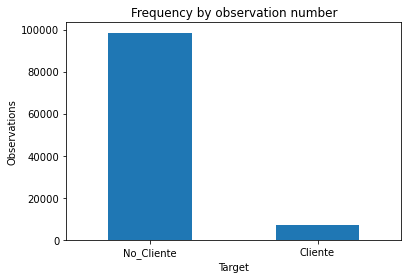

In [12]:
count_classes = pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1, 'IND_CLIENTE'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Target")
plt.ylabel("Observations");

In [13]:
print('Los clientes suponen un % del total: ', ((7009/(len(final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1])))*100))

Los clientes suponen un % del total:  6.643727843181861


**Podemos ver un claro desbalanceo donde los clientes no suponen más del 7% de las observaciones**

------------------

------------------

### 4. Creación del Modelo

#### 4.1 Dividimos el set entre features y label

In [19]:
final_df_PJ = final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1]

In [20]:
features = final_df_PJ[columnas]
labels = final_df_PJ['IND_CLIENTE']

In [21]:
features.shape

(105498, 95)

In [22]:
labels.shape

(105498,)

------------------

#### 4.2 Creamos set de entrenamiento y test

In [23]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [24]:
train_x.shape

(73848, 95)

In [25]:
test_x.shape

(31650, 95)

In [26]:
train_y.shape

(73848,)

In [27]:
test_y.shape

(31650,)

------------------

#### 4.3 Selección Hiperparámetros

Definimos una serie de hiperparámetros diferentes para comparar resultados

In [28]:
param_grid = ParameterGrid({'n_estimators': [5, 20, 50, 100, 150],
                            'max_features': [5, 'log2', 'auto', 'sqrt'],
                            'max_depth'   : [None, 3, 5, 7, 10],
                            'criterion'   : ['gini', 'entropy']
                           })

Loop para ajustar un modelo con cada combinación de hiperparámetros

In [29]:
resultados = {'params': [], 'oob_accuracy': []}

In [30]:
for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 20} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 20} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 

In [31]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(10)

,oob_accuracy,criterion,max_depth,max_features,n_estimators
104,0.993866,entropy,NaN,5,150
114,0.993839,entropy,NaN,auto,150
119,0.993839,entropy,NaN,sqrt,150
9,0.993812,gini,NaN,log2,150
14,0.993785,gini,NaN,auto,150
19,0.993785,gini,NaN,sqrt,150
109,0.993744,entropy,NaN,log2,150
4,0.993730,gini,NaN,5,150
103,0.993690,entropy,NaN,5,100
118,0.993690,entropy,NaN,sqrt,100


**Seleccionamos los mejores hiperparámetros**

In [32]:
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print('--------------------------------------------------')
print("Estimators: \n", resultados.iloc[0,:], "accuracy")

Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
Estimators: 
 oob_accuracy    0.993866
criterion        entropy
max_depth            NaN
max_features           5
n_estimators         150
Name: 104, dtype: object accuracy


--------------

--------------

#### 4.4 Modelo 1 - Baseline

Nuestro modelo Base, tendrá los parámetros obtenidos como mejores anteriormente.

**Aplicamos los mejores hiperparámetros obtenidos**

In [33]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=150,
                       n_jobs=-1, random_state=123)

Observamos los resultados del modelo

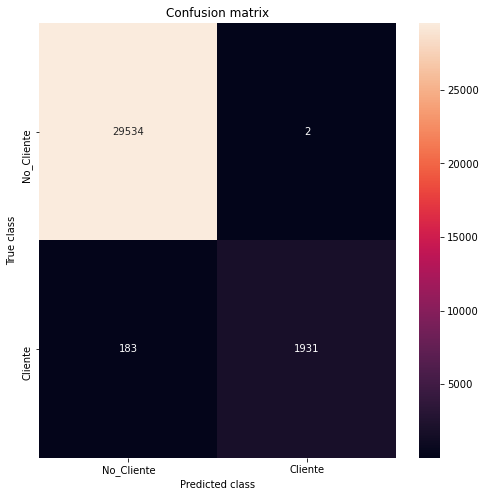

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29536
           1       1.00      0.91      0.95      2114

    accuracy                           0.99     31650
   macro avg       1.00      0.96      0.98     31650
weighted avg       0.99      0.99      0.99     31650



In [34]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [35]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [36]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,20.921023
IPCASOS,5.658599
PERF_PROMO_TOT,4.356885
CANAL_REGISTRO_1,3.271670
USU_DEPART_IDH,2.959912
USU_DEPART_DEN_POB,2.942024
1A_DESCGRUPOPROD_PERF_PROMO,2.781481
1A_DESCGRUPOPROD_FICH_PROMO,2.284263
USU_TIPO_EMPRESARIO INDIVIDUAL,2.202551
TIPOEMAIL_GOOHOTYAHMAIL,2.067120


In [37]:
feature_importances[feature_importances['important'] > 0.01].shape

(28, 1)

------

------

------

#### 4.5 Modelo - Aplicando técnicas sobre el desbalanceo

**Estrategias para el manejo de Datos Desbalanceados**

##### **4.5.1 Penalización para compensar**

In [38]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 5, 
                            max_depth = None,
                            n_jobs = -1,
                            random_state = 123,
                            class_weight = 'balanced')

rf.fit(train_x, train_y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=5, n_estimators=150, n_jobs=-1,
                       random_state=123)

Observamos los resultados del modelo

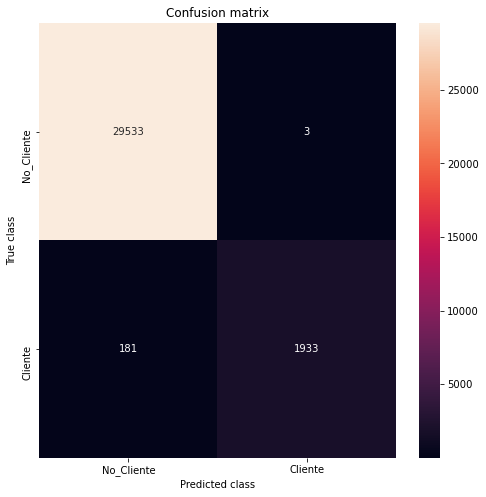

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29536
           1       1.00      0.91      0.95      2114

    accuracy                           0.99     31650
   macro avg       1.00      0.96      0.98     31650
weighted avg       0.99      0.99      0.99     31650



In [39]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [40]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [41]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,20.486402
IPCASOS,5.142025
PERF_PROMO_TOT,3.941950
USU_DEPART_IDH,3.199462
USU_DEPART_DEN_POB,3.129798
USU_TIPO_EMPRESARIO INDIVIDUAL,2.974648
1A_DESCGRUPOPROD_PERF_PROMO,2.941022
CANAL_REGISTRO_1,2.748647
1A_DESCGRUPOPROD_FICH_PROMO,2.589308
TIPOEMAIL_GOOHOTYAHMAIL,2.396887


In [42]:
feature_importances[feature_importances['important'] > 0.01].shape

(29, 1)

------

##### **4.5.2 Subsampling en la clase mayoritaria**

**RandomUnderSampler**

In [43]:
us = RandomUnderSampler(sampling_strategy = 'majority', random_state = 123)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 68953, 1: 4895})
Distribution after resampling Counter({0: 4895, 1: 4895})


In [44]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=150,
                       n_jobs=-1, random_state=123)

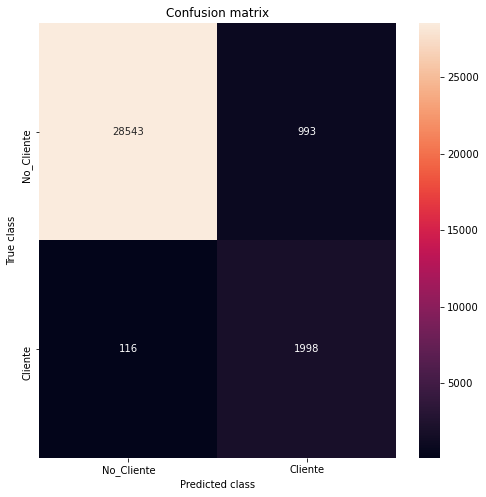

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     29536
           1       0.67      0.95      0.78      2114

    accuracy                           0.96     31650
   macro avg       0.83      0.96      0.88     31650
weighted avg       0.97      0.96      0.97     31650



In [45]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [46]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [47]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,19.116329
IPCASOS,4.725485
PERF_PROMO_TOT,4.187792
USU_TIPO_EMPRESARIO INDIVIDUAL,3.527353
USU_DEPART_IDH,3.192473
1A_DESCGRUPOPROD_PERF_PROMO,3.059661
USU_DEPART_DEN_POB,2.965874
CANAL_REGISTRO_1,2.890636
1A_DESCGRUPOPROD_FICH_PROMO,2.648326
TIPOEMAIL_GOOHOTYAHMAIL,2.303886


In [48]:
feature_importances[feature_importances['important'] > 0.01].shape

(28, 1)

------

##### **4.5.3 Oversampling en la clase minoritaria**

**SMOTE**

In [49]:
os =  SMOTE(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [50]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 68953, 1: 4895})
Distribution labels after resampling Counter({0: 68953, 1: 68953})


In [51]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=150,
                       n_jobs=-1, random_state=123)

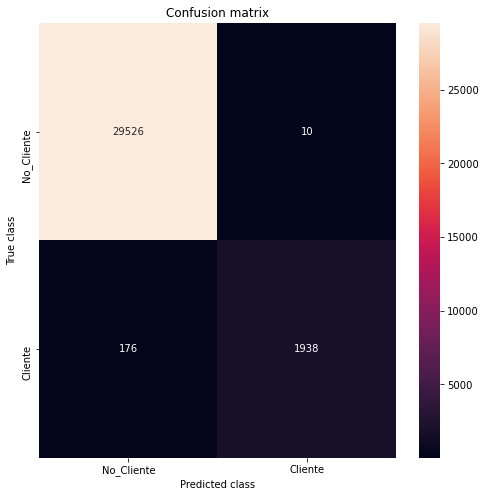

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29536
           1       0.99      0.92      0.95      2114

    accuracy                           0.99     31650
   macro avg       0.99      0.96      0.98     31650
weighted avg       0.99      0.99      0.99     31650



In [52]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [53]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [54]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,19.728424
IPCASOS,4.928360
USU_TIPO_EMPRESARIO INDIVIDUAL,4.263002
1A_DESCGRUPOPROD_PERF_PROMO,3.615818
TIPOEMAIL_GOOHOTYAHMAIL,3.216870
PERF_PROMO_TOT,3.165131
USU_DEPART_IDH,2.782596
CANAL_REGISTRO_3,2.756071
USU_DEPART_DEN_POB,2.684649
USU_TAMANIO_MC,2.336620


In [55]:
feature_importances[feature_importances['important'] > 0.01].shape

(29, 1)

------

##### **4.5.4 Combinamos OverSampling con Subsampling**

**Combinando SMOTE & RandomUnderSampler**

In [56]:
over = SMOTE(sampling_strategy = 0.3)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [57]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [58]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 68953, 1: 4895})
Distribution after resampling Counter({0: 41370, 1: 20685})


In [59]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 5, 
                            max_depth = None,  
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=150,
                       n_jobs=-1, random_state=123)

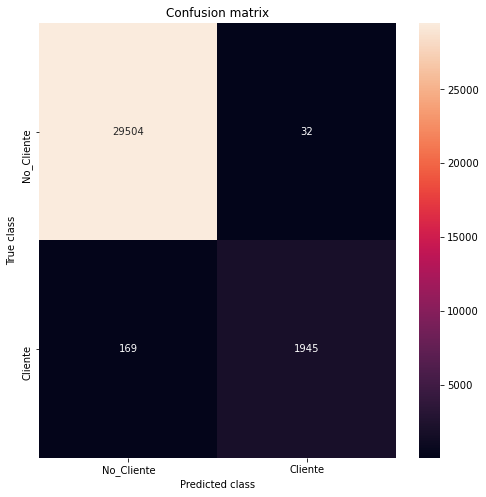

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29536
           1       0.98      0.92      0.95      2114

    accuracy                           0.99     31650
   macro avg       0.99      0.96      0.97     31650
weighted avg       0.99      0.99      0.99     31650



In [60]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [61]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [62]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
FICH_PROMO_TOT,18.617612
IPCASOS,4.851848
1A_DESCGRUPOPROD_PERF_PROMO,4.065748
USU_TIPO_EMPRESARIO INDIVIDUAL,3.877736
PERF_PROMO_TOT,3.570316
TIPOEMAIL_GOOHOTYAHMAIL,2.978602
USU_DEPART_IDH,2.796484
USU_DEPART_DEN_POB,2.793565
CANAL_REGISTRO_3,2.549287
CANAL_REGISTRO_1,2.300012


In [63]:
feature_importances[feature_importances['important'] > 0.01].shape

(27, 1)

------

**SMOTETomek**

In [64]:
os_us = SMOTETomek(sampling_strategy = 'all')
X_train_res, y_train_res = os_us.fit_resample(train_x, train_y)

In [65]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 68953, 1: 4895})
Distribution after resampling Counter({0: 68947, 1: 68947})


In [66]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=150,
                       n_jobs=-1, random_state=123)

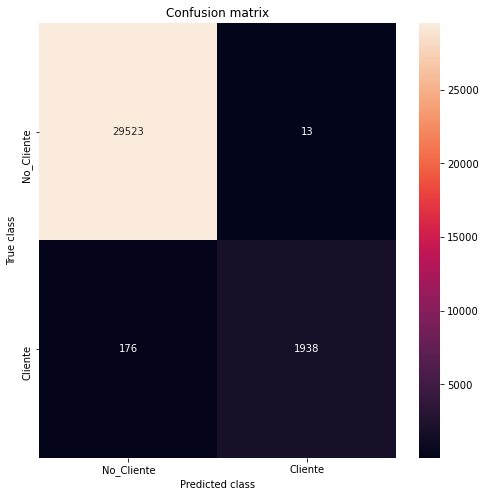

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29536
           1       0.99      0.92      0.95      2114

    accuracy                           0.99     31650
   macro avg       0.99      0.96      0.98     31650
weighted avg       0.99      0.99      0.99     31650



In [67]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [68]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [69]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
FICH_PROMO_TOT,18.582908
IPCASOS,4.689516
USU_TIPO_EMPRESARIO INDIVIDUAL,3.992941
1A_DESCGRUPOPROD_PERF_PROMO,3.579248
PERF_PROMO_TOT,3.393684
TIPOEMAIL_GOOHOTYAHMAIL,3.200245
USU_DEPART_DEN_POB,2.752784
USU_DEPART_IDH,2.746621
CANAL_REGISTRO_3,2.714232
1A_DESCGRUPOPROD_FICH_PROMO,2.346844


In [70]:
feature_importances[feature_importances['important'] > 0.01].shape

(30, 1)

------

------

##### **4.5.5 Ensamble de Modelos con Balanceo**

Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging y el modelo será un RandomForest.

**Bagging**

In [71]:
bbc = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion = 'entropy', 
                                                                        n_estimators = 150, 
                                                                        max_features = 5, 
                                                                        max_depth = None, 
                                                                        n_jobs = -1,
                                                                        random_state = 123),
                                sampling_strategy = 'all',
                                n_estimators = 40,
                                replacement = False,
                                random_state = 123)

bbc.fit(train_x, train_y)

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                                max_features=5,
                                                                n_estimators=150,
                                                                n_jobs=-1,
                                                                random_state=123),
                          n_estimators=40, random_state=123,
                          sampling_strategy='all')

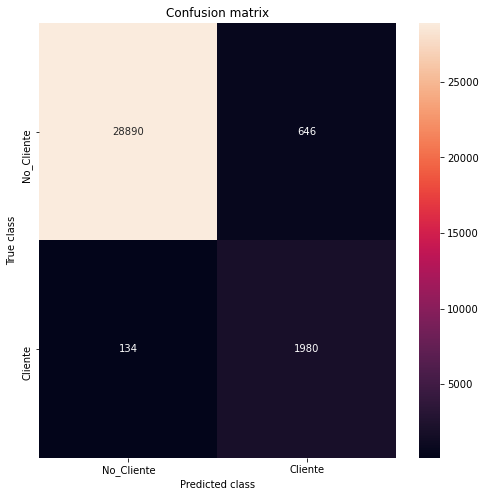

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29536
           1       0.75      0.94      0.84      2114

    accuracy                           0.98     31650
   macro avg       0.87      0.96      0.91     31650
weighted avg       0.98      0.98      0.98     31650



In [72]:
pred_y = bbc.predict(test_x)
mostrar_resultados(test_y, pred_y)

------

**RUSBoostClassifier**

In [73]:
RUS = RUSBoostClassifier(base_estimator = RandomForestClassifier(criterion = 'entropy', 
                                                                n_estimators = 150, 
                                                                max_features = 5, 
                                                                max_depth = None,
                                                                 n_jobs = -1,
                                                                 random_state = 123),
                                sampling_strategy = 'majority',
                                n_estimators = 20,
                                replacement = False,
                                random_state = 123)

RUS.fit(train_x, train_y)

RUSBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         max_features=5,
                                                         n_estimators=150,
                                                         n_jobs=-1,
                                                         random_state=123),
                   n_estimators=20, random_state=123,
                   sampling_strategy='majority')

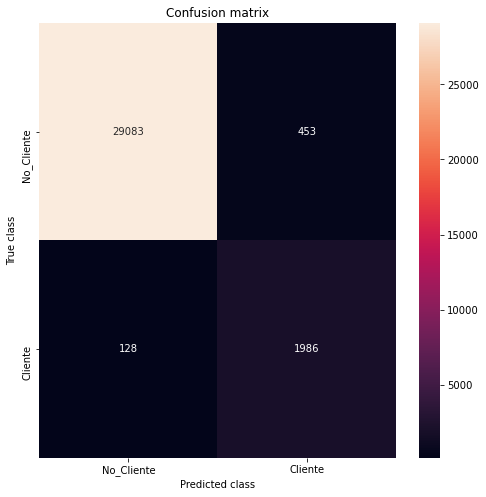

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29536
           1       0.81      0.94      0.87      2114

    accuracy                           0.98     31650
   macro avg       0.90      0.96      0.93     31650
weighted avg       0.98      0.98      0.98     31650



In [74]:
pred_y = RUS.predict(test_x)
mostrar_resultados(test_y, pred_y)

---------------

---------------

---------------

# CONCLUSIONES

| Modelo | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | NoClientes F1-score | Clientes - Precision | Clientes - Recall | Clientes F1-score | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Baseline | 0.99 | 0.99 | 1.00 | **1.00** | 1.00 | 0.91 | **0.95** | 28 |  

### **Resultados** 

| Modelo |Tecnica |Algoritmo   | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | NoClientes F1-score | Clientes - Precision | Clientes - Recall | Clientes F1-score | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Modelo 1 | **Penalización para compensar** | -- | 0.99 | 0.99 | 1.00 | **1.00** | 1.00 | 0.91 | **0.95** | 29 |
| Modelo 2 | **Subsampling en la clase mayoritaria** | RandomUnderSampler | 0.96 | 1.00 | 0.97 | **0.98** | 0.67 | 0.95 | **0.78** | 28 |
| Modelo 3 | **Oversampling en la clase minoritaria** | SMOTE| 0.99 | 0.99 | 1.00 | **1.00** | 0.99 | 0.92 | **0.95** | 29 |
| Modelo 4 | **Combinamos OverSampling con Subsampling** | SMOTE & RandomUnderSampler | 0.99 | 0.99 | 1.00 | **1.00** | 0.98 | 0.92 | **0.95** | 27 |
| Modelo 5 | **Combinamos OverSampling con Subsampling** | SMOTE-Tomek| 0.99 | 0.99 | 1.00 | **1.00** | 0.99 | 0.92 | **0.95** | 30 |
| Modelo 6 | **Ensamble de Modelos con Balanceo** | BalancedBaggingClassifier| 0.98 | 1.00 | 0.98 | **0.99** | 0.75 | 0.94 | **0.84**  | -- |
| Modelo 7 | **Ensamble de Modelos con Balanceo** | RUSBoostClassifier| 0.98 | 1.00 | 0.98 | **0.99** | 0.81 | 0.94 | **0.87** | -- |

Tras los resultados obtenidos y expuestos, podemos concluir que las técnicas que mejores resultados nos han proporcionado estan entre **Penalización para compensar**, **Oversampling en la clase minoritaria** y **Combinamos OverSampling con Subsampling**. Los resultados de las técnicas son muy parecidos al del modelo Base.

Análizando las diferentes métricas obtenidas, en primer lugar nos fijamos que todos las diferentes técnicas tienen un F1-score de la clase No Clientes muy similar entre ellas, por lo que marcará la diferencias será la clase Clientes.

Observando que el modelo base y las técnicas SMOTE y SMOTE-Tomek son los que mejor F1 en la clase clientes tienen, analizaremos en detalle la precisión y recall de cada uno. Unicamente la técnica de **ensamblado de modelos con balanceo** son los que peor resultado han proporcionado, en los que a F1 de la clase Clientes se refiere. 

Sin embargo, entendiendo que el objetivo del negocio es poder desarrollar una estrategia en base a un determinado grupo, lo que premiaremos es el modelo que mejor recall tenga, ya que lo que interesa es detectar bien la clase clientes. 

El modelo que mejor responde a esto es el que utiliza la técnica **Ensamble de Modelos con Balanceo**, en concreto un boosting.